# Description

Plots to analyze evaluation scores visually based on parameters samples in runs.
For dVGFdF11, only 4 parameters are considered where one is speed and the other
three decide the infection chance to neighboring cells. Therefore the assumption
is that we can reduce these to only one in order to plot scores w.r.t. only two
parameters.

# Setup

For now add param value columns from names, later, do it in evaluation and remove this one.

In [1]:
pval_ttest_lastframe_cols = ["infected-count-lastframe-t-test-pvalue", "area-lastframe-t-test-pvalue", "radial-velocity-lastframe-t-test-pvalue"]
pval_ztest_lastframe_cols = ["infected-count-lastframe-z-test-pvalue", "area-lastframe-z-test-pvalue", "radial-velocity-lastframe-z-test-pvalue"]
pval_corxi2_lastframe_cols = ["infected-count-lastframe-corxi2-pval", "area-lastframe-corxi2-pval", "radial-velocity-lastframe-corxi2-pval"]
pval_corxi2_cols = ["infected-count-corxi2-pval", "area-corxi2-pval", "radial-velocity-corxi2-pval"]
zscore_sums_cols = ["zscores-normalized-sum", "zscores-lastframe-normalized-sum"]

params = ["randomwalk_speed", "c2c_k", "c2c_x0", "c2c_radius"]

In [67]:
import pandas as pd
from utils import *
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from scipy.interpolate import Rbf

eval_csv = "/Users/ashkanhzdr/workspace/infectio-mesa/output/dVGFdF11/0_evaluation/bulk_evaluate.csv"

df = read_and_clean_df(eval_csv)
df = add_param_cols_from_experiment_name(df)

In [68]:
rw_speed = df["randomwalk_speed"].values
c2c = df[["c2c_k", "c2c_x0", "c2c_radius"]].values
rw_speed.shape, c2c.shape

((2106,), (2106, 3))

In [69]:
# Apply PCA to reduce the 3 infection parameters to 1
pca = PCA(n_components=1)
c2c_pc = pca.fit_transform(c2c)

# (not useful) Method: Scatter plot and marker size for scores

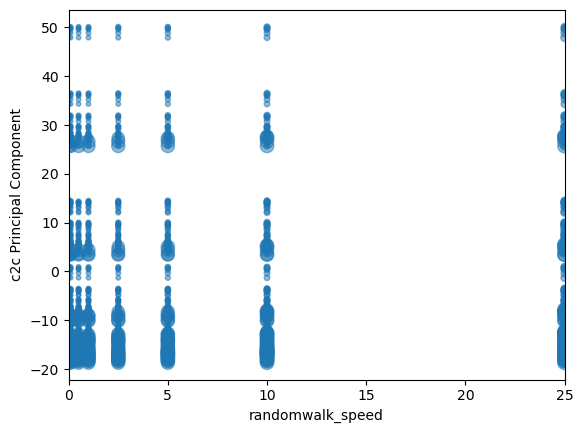

In [66]:
def plot_scatter(scorename, xlim=None):
    scores = df[scorename].values
    marker_sizes = [10 + 100 * (score - min(scores)) / (max(scores) - min(scores)) for score in scores]

    plt.scatter(rw_speed, c2c_pc, s=marker_sizes, alpha=0.5)

    if xlim:
        plt.xlim(xlim)

    
    plt.xlabel('randomwalk_speed')
    plt.ylabel('c2c Principal Component')
    plt.show()

plot_scatter("zscores-normalized-sum", xlim=(0, 25))

# Method: RBF interpolation

1. Dimensionality Reduction Using PCA for c2c params
2. use an intepolation for scores given rw_speed and c2c_principal_component (scipy.interpolate.RBFnterpolator)
3. Contoue plot

In [72]:
def plot_rbfinterpolate(scorename, xlim=None, ylim=None, function='multiquadric'):
    score = df[scorename].values

    # Perform RBF interpolation on the reduced parameter space
    rbf_interpolator = Rbf(rw_speed, c2c_pc, score, function=function)

    # Generate a grid of points to interpolate the score over
    grid_x, grid_y = np.mgrid[rw_speed.min():rw_speed.max():100j, c2c_pc.min():c2c_pc.max():100j]
    interpolated_scores = rbf_interpolator(grid_x, grid_y)

    # Create a 2D contour plot of the interpolated score
    plt.figure(figsize=(10, 8))
    
    # Contour plot with the first colormap
    contour = plt.contourf(grid_x, grid_y, interpolated_scores, levels=20, cmap='viridis')

    # Scatter plot with a second colormap based on score values
    scatter = plt.scatter(rw_speed, c2c_pc, c=score, cmap='plasma', s=30, edgecolor='white', alpha=0.5)

    # Add the first colorbar (for the contour plot)
    plt.colorbar(contour, label='Interpolated Score')

    # Add the second colorbar (for the scatter plot)
    cbar_scatter = plt.colorbar(scatter, label=scorename + ' Sample Score')
    
    # Customize plot details
    plt.title(scorename + ' interpolated with RBF(' + function + ') and Sampled Points')
    plt.xlabel('randomwalk_speed')
    plt.ylabel('c2c Principal Component')
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)

    plt.show()

## Example for zscore-normalized-sum and circularity

/opt/homebrew/Caskroom/miniconda/base/envs/infectio-mesa/lib/python3.11/site-packages/scipy/interpolate/_rbf.py:268: LinAlgWarning: Ill-conditioned matrix (rcond=5.06117e-22): result may not be accurate.
  self.nodes = linalg.solve(self.A, self.di)


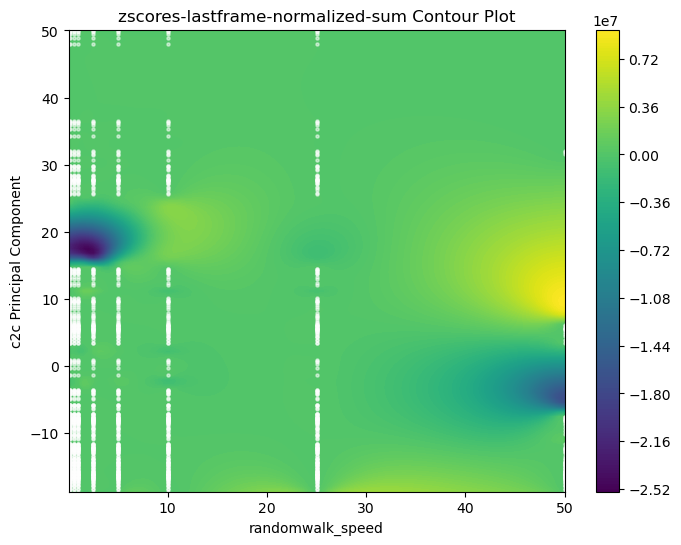

/opt/homebrew/Caskroom/miniconda/base/envs/infectio-mesa/lib/python3.11/site-packages/scipy/interpolate/_rbf.py:268: LinAlgWarning: Ill-conditioned matrix (rcond=5.06117e-22): result may not be accurate.
  self.nodes = linalg.solve(self.A, self.di)


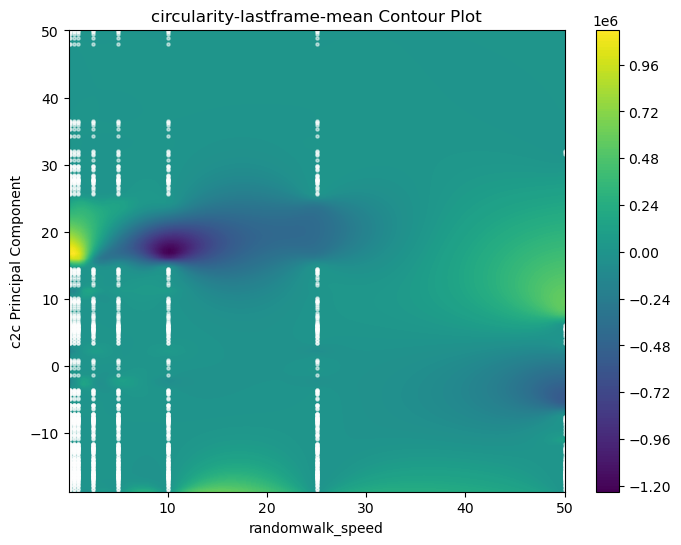

In [42]:
plot_rbfinterpolate('zscores-lastframe-normalized-sum')
plot_rbfinterpolate('circularity-lastframe-mean')

## Reversirsing the PCA to get back to the original space

In [36]:
# order is: c2c_k, c2c_x0, c2c_radius
print("rw_speed=0.1 or 0.5 ", pca.inverse_transform([20]))
print("rw_speed=50 ", pca.inverse_transform([-4]))

rw_speed=0.1 or 0.5  [30.41628821 23.58790092 17.71670808]
rw_speed=50  [ 9.05030361 12.71318905 18.82816835]


In [76]:
a = [[15], [17.5], [20], [22.5], [25]]
pca.inverse_transform(a)

array([[25.96504142, 21.32233595, 17.94826231],
       [28.19066481, 22.45511844, 17.8324852 ],
       [30.41628821, 23.58790092, 17.71670808],
       [32.6419116 , 24.72068341, 17.60093097],
       [34.867535  , 25.8534659 , 17.48515386]])

For the 1st region no samples, but some of the surrounding ones are:


## Plotting more scores

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2106 entries, 0 to 2111
Data columns (total 33 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   experiment_name                          2106 non-null   object 
 1   infected-count-zscore                    2106 non-null   object 
 2   infected-count-zscore-mean               2106 non-null   float64
 3   infected-count-lastframe-zscore          2106 non-null   object 
 4   infected-count-lastframe-zscore-mean     2106 non-null   float64
 5   infected-count-corxi2-pval               2106 non-null   float64
 6   infected-count-lastframe-corxi2-pval     2106 non-null   float64
 7   infected-count-lastframe-t-test-pvalue   2106 non-null   float64
 8   infected-count-lastframe-z-test-pvalue   2106 non-null   float64
 9   area-zscore                              2106 non-null   object 
 10  area-zscore-mean                         2106 non-nul

/opt/homebrew/Caskroom/miniconda/base/envs/infectio-mesa/lib/python3.11/site-packages/scipy/interpolate/_rbf.py:268: LinAlgWarning: Ill-conditioned matrix (rcond=5.06117e-22): result may not be accurate.
  self.nodes = linalg.solve(self.A, self.di)


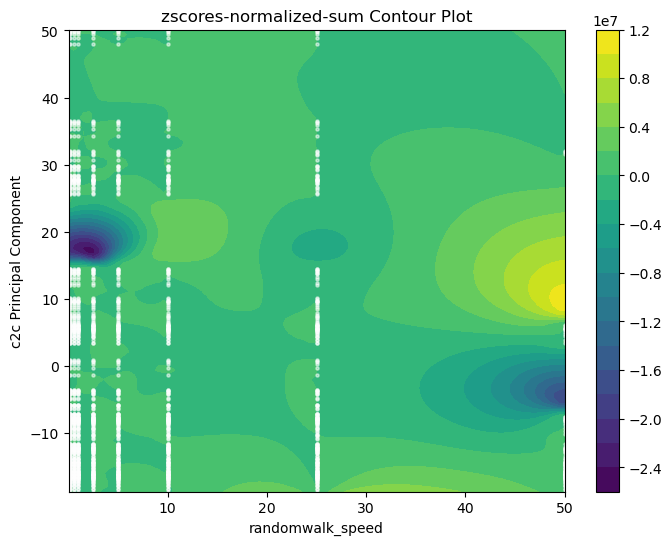

/opt/homebrew/Caskroom/miniconda/base/envs/infectio-mesa/lib/python3.11/site-packages/scipy/interpolate/_rbf.py:268: LinAlgWarning: Ill-conditioned matrix (rcond=5.06117e-22): result may not be accurate.
  self.nodes = linalg.solve(self.A, self.di)


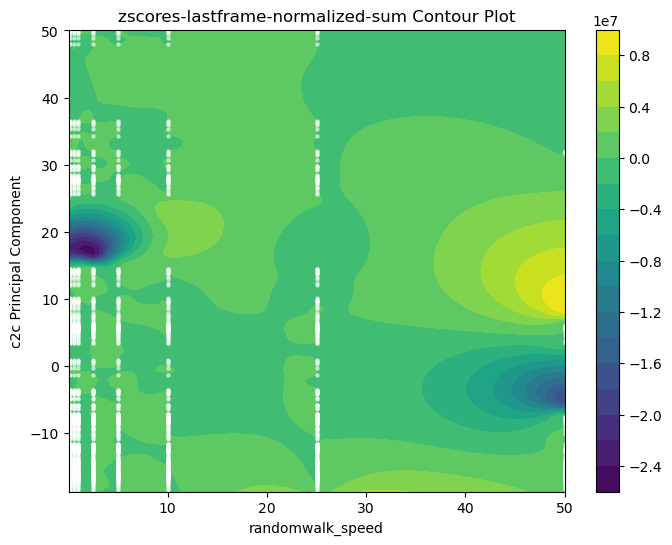

/opt/homebrew/Caskroom/miniconda/base/envs/infectio-mesa/lib/python3.11/site-packages/scipy/interpolate/_rbf.py:268: LinAlgWarning: Ill-conditioned matrix (rcond=5.06117e-22): result may not be accurate.
  self.nodes = linalg.solve(self.A, self.di)


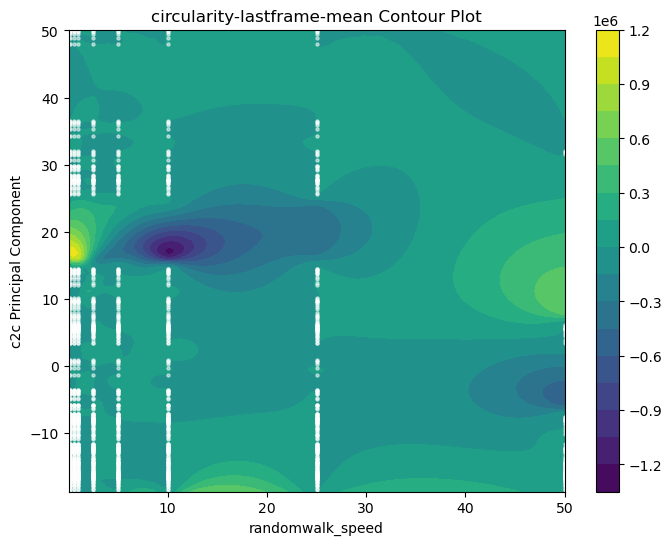

/opt/homebrew/Caskroom/miniconda/base/envs/infectio-mesa/lib/python3.11/site-packages/scipy/interpolate/_rbf.py:268: LinAlgWarning: Ill-conditioned matrix (rcond=5.06117e-22): result may not be accurate.
  self.nodes = linalg.solve(self.A, self.di)


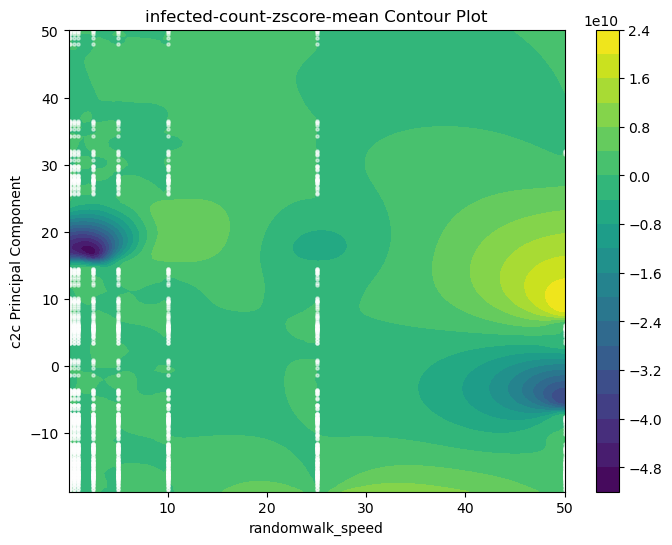

/opt/homebrew/Caskroom/miniconda/base/envs/infectio-mesa/lib/python3.11/site-packages/scipy/interpolate/_rbf.py:268: LinAlgWarning: Ill-conditioned matrix (rcond=5.06117e-22): result may not be accurate.
  self.nodes = linalg.solve(self.A, self.di)


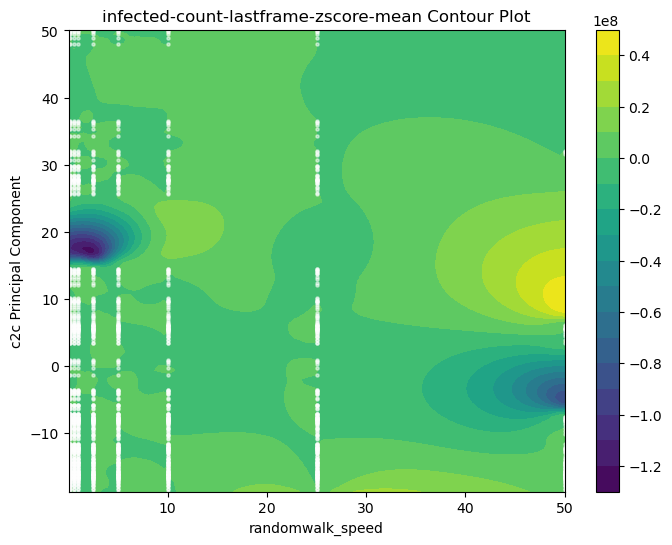

/opt/homebrew/Caskroom/miniconda/base/envs/infectio-mesa/lib/python3.11/site-packages/scipy/interpolate/_rbf.py:268: LinAlgWarning: Ill-conditioned matrix (rcond=5.06117e-22): result may not be accurate.
  self.nodes = linalg.solve(self.A, self.di)


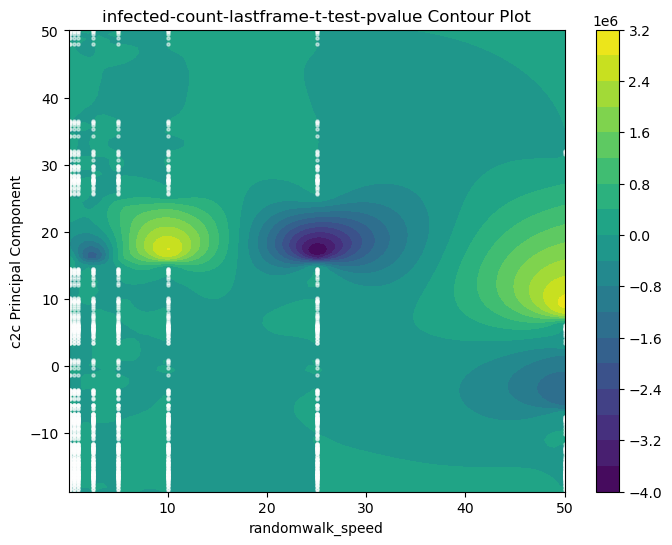

/opt/homebrew/Caskroom/miniconda/base/envs/infectio-mesa/lib/python3.11/site-packages/scipy/interpolate/_rbf.py:268: LinAlgWarning: Ill-conditioned matrix (rcond=5.06117e-22): result may not be accurate.
  self.nodes = linalg.solve(self.A, self.di)


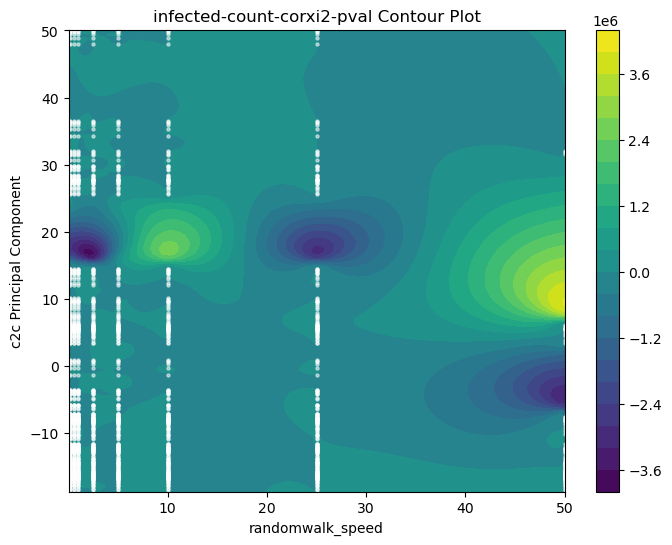

In [29]:
scorenames = ["zscores-normalized-sum", "zscores-lastframe-normalized-sum", "circularity-lastframe-mean", "infected-count-zscore-mean", "infected-count-lastframe-zscore-mean", "infected-count-lastframe-t-test-pvalue", "infected-count-corxi2-pval"]
for s in scorenames:
    plot_rbfinterpolate(s)